## Aula 6 - Eficiência do Módulo e Métricas de Performance da Usina FV

#### Etapas da Aula

1) Eficiência do Módulo com Variação de Irradiância

2) Eficiência do Módulo com Variação de Temperatura

3) Mapeamento de Eficiência do Módulo com Dados Reais

4) Aplicação de Métricas para Avaliação de Performance da Usina FV

- Performance Ratio (PR)

- Yield Final (Yf)

- Yield Referencial (Yr)

- Fator de Capacidade (FC)

#### Modelagem da De Soto

In [123]:
#Bibliotecas
import pvlib
from pvlib import pvsystem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann, elementary_charge

In [124]:
def desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref):
    desoto_fit_params = pvlib.ivtools.sdm.fit_desoto(Vmp,
                                                     Imp,
                                                     Voc, 
                                                     Isc,
                                                     alpha,
                                                     beta,
                                                     Ns,
                                                     EgRef,
                                                     dEgdT,
                                                     Tref, 
                                                     Gref,
                                                     root_kwargs = {'method': 'lm', 'options':{'maxiter':10000, 'xtol': 1e-3, 'gtol': 1e-3}})
    desoto_fit_params[0]

    fitted_params = desoto_fit_params[0]

    desoto_params_dict = fitted_params

    results_df_desoto = pd.DataFrame(columns = ['a_ref', 'Ipv_ref', 'Io_ref', 'Rp_ref', 'R_s'])

    results_df_desoto.loc[1] = [desoto_params_dict['a_ref'], desoto_params_dict['I_L_ref'], desoto_params_dict['I_o_ref'],
                                desoto_params_dict['R_sh_ref'], desoto_params_dict['R_s']]
    return(results_df_desoto)

def desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100):
    diode_params_desoto = pvlib.pvsystem.calcparams_desoto(irrad, 
                                                          temp_cell, 
                                                          alpha, 
                                                          a_ref, 
                                                          Ipv_ref, 
                                                          Io_ref, 
                                                          Rp_ref, 
                                                          R_s, 
                                                          EgRef, 
                                                          dEgdT, 
                                                          Gref, 
                                                          Tref)
    SDE_params = {
        'photocurrent': diode_params_desoto[0],
        'saturation_current': diode_params_desoto[1],
        'resistance_series': diode_params_desoto[2],
        'resistance_shunt': diode_params_desoto[3],
        'nNsVth': diode_params_desoto[4]
    }

    curve_info = pvsystem.singlediode(method=method, **SDE_params)
    v = pd.DataFrame(np.linspace(0, curve_info['v_oc'], number_of_points))
    i = pd.DataFrame(pvsystem.i_from_v(voltage=v, method=method, **SDE_params))

    return ({'Key_Points': curve_info,
             'Voltage': v,
             'Current': i})

#Constantes necessárias para a modelagem em STC
EgRef=1.121 #Valence energy band-gap for Crystalline Silicon
dEgdT=- 0.0002677 #
Tref = 25 #Temperature (°C) under STC
Gref = 1000 #Irradiance (W/m²) under STC
k = Boltzmann
q = elementary_charge

In [125]:
#Características do Módulo
Vmp = 30.8 #Voltage at Maximum Power
Imp = 8.75 #Current at Maximum Power
Voc = 37.9 #Open-Circuit Voltage
Isc = 9.32 #Short-Circuit Current
alpha = 0.05*Isc/100 # Alpha_isc (%/A) * Short-Circuit Current
beta = (-0.31)*Voc/100 # Beta_voc (%/V) * Open-Circuit Voltage
gamma = -0.41
Ns = 60 #Number of PV Cells in Series
A_c = 1.6368 #The Area of PV Module's Surface

In [126]:
# Condições de Irradiância em STC (1000 W/m² e 25°C)
irrad = 1000
temp_cell = 25

In [127]:
desoto_ref_parameters = desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref)
print('Os 5 parâmetros do SDM em STC')
desoto_ref_parameters

Os 5 parâmetros do SDM em STC


,a_ref,Ipv_ref,Io_ref,Rp_ref,R_s
1,1.466828,9.331172,5.510305e-11,256.566152,0.306243


In [128]:
a_ref = desoto_ref_parameters['a_ref'][1]
Ipv_ref = desoto_ref_parameters['Ipv_ref'][1]
Io_ref = desoto_ref_parameters['Io_ref'][1]
Rp_ref = desoto_ref_parameters['Rp_ref'][1]
R_s = desoto_ref_parameters['R_s'][1]

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100)
print('Pontos chave da Curva IV')
results['Key_Points']

Pontos chave da Curva IV


OrderedDict([('i_sc', 9.320047289732555),
             ('v_oc', 37.90170029341334),
             ('i_mp', array(8.7499835)),
             ('v_mp', array(30.80051909)),
             ('p_mp', 269.50403396639945),
             ('i_x', 9.246117084999788),
             ('i_xx', 6.207336752963065)])

Curva IV em STC destacando o Ponto de Máxima Potência


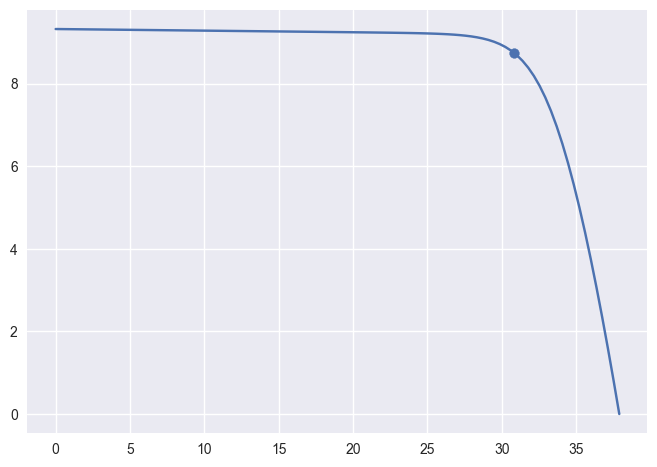

In [129]:
print('Curva IV em STC destacando o Ponto de Máxima Potência')
plt.plot(results['Voltage'], results['Current'])
plt.scatter(results['Key_Points']['v_mp'], results['Key_Points']['i_mp'])
plt.show()

1. Eficiência do Módulo com Variação de Irradiância 

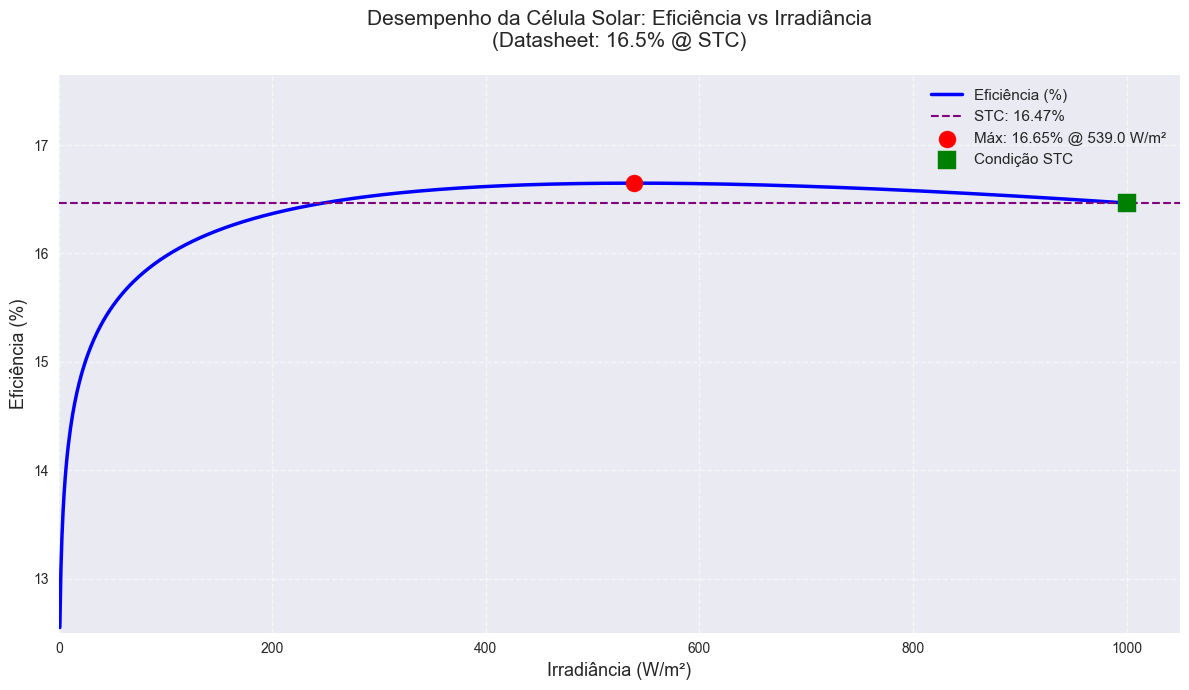

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# Configuração do estilo do gráfico
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 7))

# Dados
irrad = np.linspace(1, 1000, 1000)
temp_cell = np.full(1000, 25)

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref,
                            Rp_ref, R_s, EgRef, dEgdT, Gref, Tref,
                            method='lambertw', number_of_points=100)
eff = (results['Key_Points']['p_mp'])/(A_c*irrad) * 100  # Já convertido para %

# Encontrando o ponto de máxima eficiência
max_eff_idx = np.argmax(eff)
max_eff = eff[max_eff_idx]
max_irrad = irrad[max_eff_idx]

# Ponto STC
stc_idx = np.where(irrad >= 1000)[0][0]
stc_eff = eff[stc_idx]

# Plot principal
plt.plot(irrad, eff, 'b-', linewidth=2.5, label='Eficiência (%)')

# Linha horizontal no valor STC
plt.axhline(y=stc_eff, color='purple', linestyle='--', linewidth=1.5,
           label=f'STC: {stc_eff:.2f}%')

# Destaque para ponto de máxima eficiência
plt.scatter(max_irrad, max_eff, color='red', s=150, zorder=5,
           label=f'Máx: {max_eff:.2f}% @ {max_irrad:.1f} W/m²')

# Destaque para ponto STC
plt.scatter(1000, stc_eff, color='green', s=150, zorder=5,
           marker='s', label='Condição STC')

# Elementos gráficos
plt.title('Desempenho da Célula Solar: Eficiência vs Irradiância\n(Datasheet: 16.5% @ STC)',
         fontsize=15, pad=20)
plt.xlabel('Irradiância (W/m²)', fontsize=13)
plt.ylabel('Eficiência (%)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)

# Configurações finais
plt.xlim(0, 1050)
plt.ylim(12.5, max(16.5, max_eff)+1)  # Considerando o valor do datasheet
plt.legend(loc='upper right', fontsize=11, framealpha=1)
plt.tight_layout()

plt.show()

2. Eficiência do Módulo com Variação de Irradiância

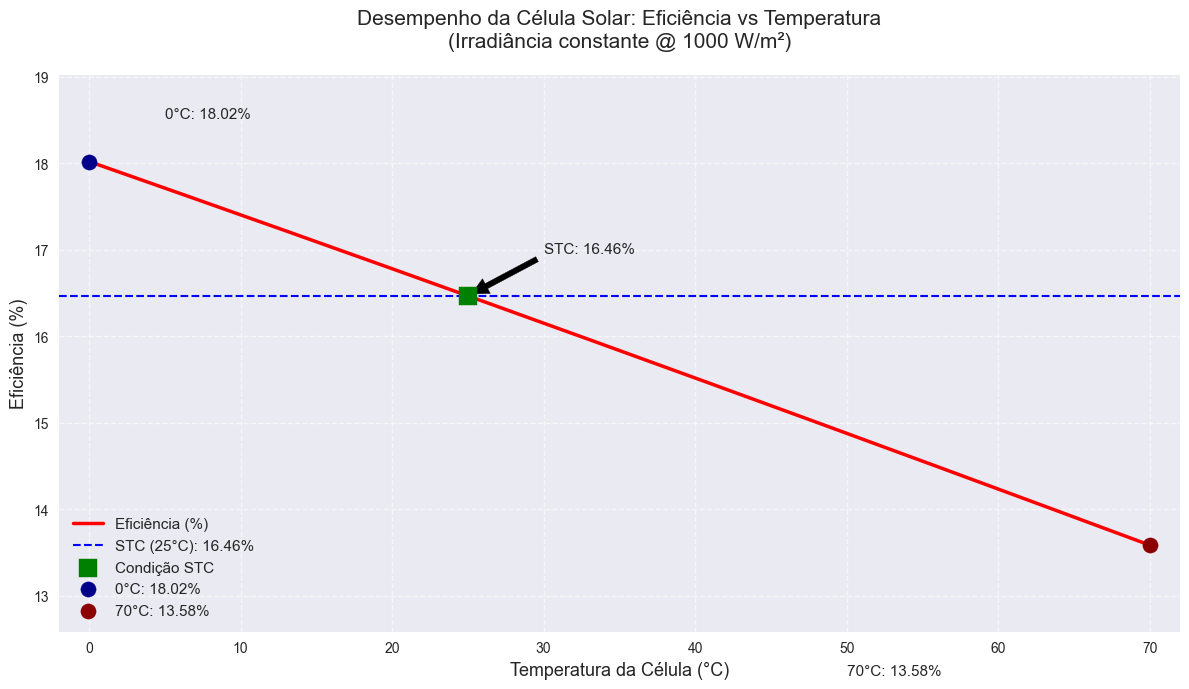

In [131]:
import numpy as np
import matplotlib.pyplot as plt

# Configuração do estilo do gráfico
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 7))

# Dados - Irradiância fixa e temperatura variável
irrad = np.full(1000, 1000)  # 1000 W/m² constante
temp_cell = np.linspace(0, 70, 1000)  # Temperatura de 0 a 70°C

# Cálculo dos parâmetros
results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref,
                             Rp_ref, R_s, EgRef, dEgdT, Gref, Tref,
                             method='lambertw', number_of_points=100)
eff = (results['Key_Points']['p_mp'])/(A_c*irrad) * 100  # Eficiência em %

# Encontrando pontos importantes
stc_temp = 25  # Temperatura STC
stc_idx = np.abs(temp_cell - stc_temp).argmin()
stc_eff = eff[stc_idx]

min_temp_eff = eff[0]  # Eficiência em 0°C
max_temp_eff = eff[-1]  # Eficiência em 70°C

# Plot principal
plt.plot(temp_cell, eff, 'r-', linewidth=2.5, label='Eficiência (%)')

# Linha horizontal no valor STC
plt.axhline(y=stc_eff, color='blue', linestyle='--', linewidth=1.5,
           label=f'STC (25°C): {stc_eff:.2f}%')

# Destaque para ponto STC
plt.scatter(stc_temp, stc_eff, color='green', s=150, zorder=5,
           marker='s', label='Condição STC')

# Destaque para pontos extremos
plt.scatter(temp_cell[0], min_temp_eff, color='darkblue', s=120, zorder=5,
           label=f'0°C: {min_temp_eff:.2f}%')
plt.scatter(temp_cell[-1], max_temp_eff, color='darkred', s=120, zorder=5,
           label=f'70°C: {max_temp_eff:.2f}%')

# Elementos gráficos
plt.title('Desempenho da Célula Solar: Eficiência vs Temperatura\n(Irradiância constante @ 1000 W/m²)',
         fontsize=15, pad=20)
plt.xlabel('Temperatura da Célula (°C)', fontsize=13)
plt.ylabel('Eficiência (%)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)

# Anotações
plt.annotate(f'STC: {stc_eff:.2f}%', xy=(stc_temp, stc_eff),
            xytext=(stc_temp+5, stc_eff+0.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=11)

plt.annotate(f'0°C: {min_temp_eff:.2f}%', xy=(temp_cell[0], min_temp_eff),
            xytext=(temp_cell[0]+5, min_temp_eff+0.5),
            fontsize=11)

plt.annotate(f'70°C: {max_temp_eff:.2f}%', xy=(temp_cell[-1], max_temp_eff),
            xytext=(temp_cell[-1]-20, max_temp_eff-1.5),
            fontsize=11)

# Configurações finais
plt.xlim(-2, 72)
plt.ylim(min(eff)-1, max(eff)+1)
plt.legend(loc='lower left', fontsize=11, framealpha=1)
plt.tight_layout()

plt.show()

3. Mapeamento de Eficiência do Módulo com Dados Reais

In [132]:
#Import Data
#Localização da Universidade de Oregon

df_weather = pvlib.iotools.read_midc_raw_data_from_nrel('UOSMRL',               # Station id
                                                    pd.Timestamp('20230601'),   # Start date YYYYMMDD
                                                    pd.Timestamp('20230607'))   # End date  YYYYMMDD

df_weather.head(3)

,Unnamed: 0,Year,DOY,PST,SR20 Temp [deg C],Direct NIP [W/m^2],Diffuse [W/m^2],Global LI-200 [W/m^2],Relative Humidity [%],Air Temperature [deg C],...,CHP1 Temp [deg K],CMP22 Temp [deg K],Avg Wind Direction @ 10m [deg from N],Zenith Angle [degrees],Azimuth Angle [degrees],Airmass,Solar Eclipse Shading,Direct SAMPA/Bird (calc) [W/m^2],Global SAMPA/Bird (calc) [W/m^2],Diffuse SAMPA/Bird (calc) [W/m^2]
2023-06-01 00:00:00-08:00,0,2023,152,0,10.63,13.04,-1.298,0.029,70.71,10.86,...,283.2,284.6,306.1,113.87990,357.44185,-1.0,0,0.0,0.0,0.0
2023-06-01 00:01:00-08:00,0,2023,152,1,10.63,13.05,-1.368,0.029,70.84,10.82,...,283.2,284.6,307.9,113.88743,357.69513,-1.0,0,0.0,0.0,0.0
2023-06-01 00:02:00-08:00,0,2023,152,2,10.63,13.05,-1.394,0.032,70.75,10.82,...,283.2,284.6,323.3,113.89417,357.94844,-1.0,0,0.0,0.0,0.0


In [133]:
df_weather.keys()

Index(['Unnamed: 0', 'Year', 'DOY', 'PST', 'SR20 Temp [deg C]',
       'Direct NIP [W/m^2]', 'Diffuse [W/m^2]', 'Global LI-200 [W/m^2]',
       'Relative Humidity [%]', 'Air Temperature [deg C]',
       'Avg Wind Speed @ 10m [m/s]', 'Station Pressure [mBar]',
       'Downwelling IR PIR [W/m^2]', 'Instrument Net PIR [W/m^2]',
       'PIR Case Temp [deg K]', 'PIR Dome Temp [deg K]',
       'Logger Battery [VDC]', 'Direct CHP1 [W/m^2]', 'Global CMP22 [W/m^2]',
       'CHP1 Temp [deg K]', 'CMP22 Temp [deg K]',
       'Avg Wind Direction @ 10m [deg from N]', 'Zenith Angle [degrees]',
       'Azimuth Angle [degrees]', 'Airmass', 'Solar Eclipse Shading',
       'Direct SAMPA/Bird (calc) [W/m^2]', 'Global SAMPA/Bird (calc) [W/m^2]',
       'Diffuse SAMPA/Bird (calc) [W/m^2]'],
      dtype='object')

In [134]:
df_weather = df_weather[['Global CMP22 [W/m^2]', 'Diffuse [W/m^2]',
                         'Direct CHP1 [W/m^2]','Air Temperature [deg C]',
                         'Avg Wind Speed @ 10m [m/s]', 'Station Pressure [mBar]']]
# Rename the columns
df_weather.columns = ['ghi', 'dhi', 'dni', 'temp_air', 'wind_speed', 'air_pressure']

In [135]:
df_weather

,ghi,dhi,dni,temp_air,wind_speed,air_pressure
2023-06-01 00:00:00-08:00,-0.412,-1.298,0.425,10.86,1.550,999.080
2023-06-01 00:01:00-08:00,-0.412,-1.368,0.425,10.82,2.775,999.095
2023-06-01 00:02:00-08:00,-0.400,-1.394,0.425,10.82,2.550,999.073
2023-06-01 00:03:00-08:00,-0.389,-1.374,0.425,10.86,2.288,999.097
2023-06-01 00:04:00-08:00,-0.374,-1.387,0.425,10.89,2.575,999.098
...,...,...,...,...,...,...
2023-06-07 23:55:00-08:00,-0.023,-0.952,0.425,12.81,0.938,997.421
2023-06-07 23:56:00-08:00,-0.029,-1.015,0.425,12.96,0.337,997.429
2023-06-07 23:57:00-08:00,-0.028,-0.965,0.425,12.94,1.100,997.427
2023-06-07 23:58:00-08:00,-0.045,-1.134,0.425,13.00,1.075,997.426


<Axes: >

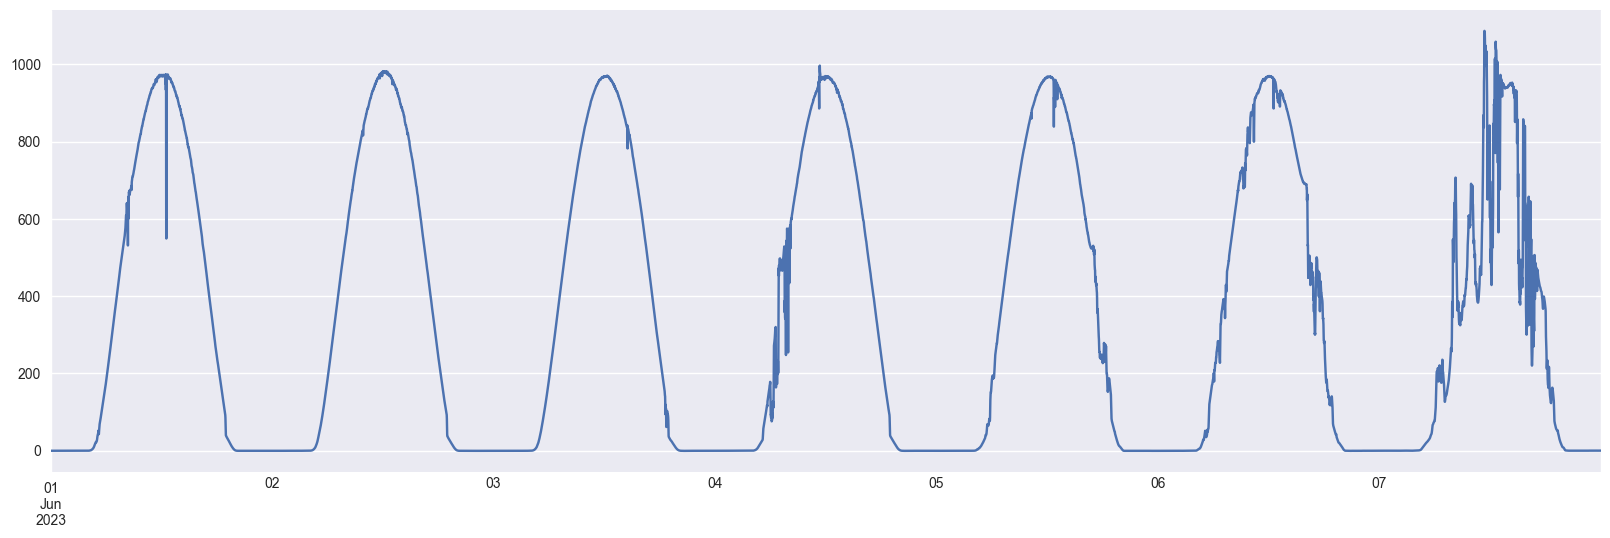

In [136]:
df_weather['ghi'].plot(figsize=(20,6))

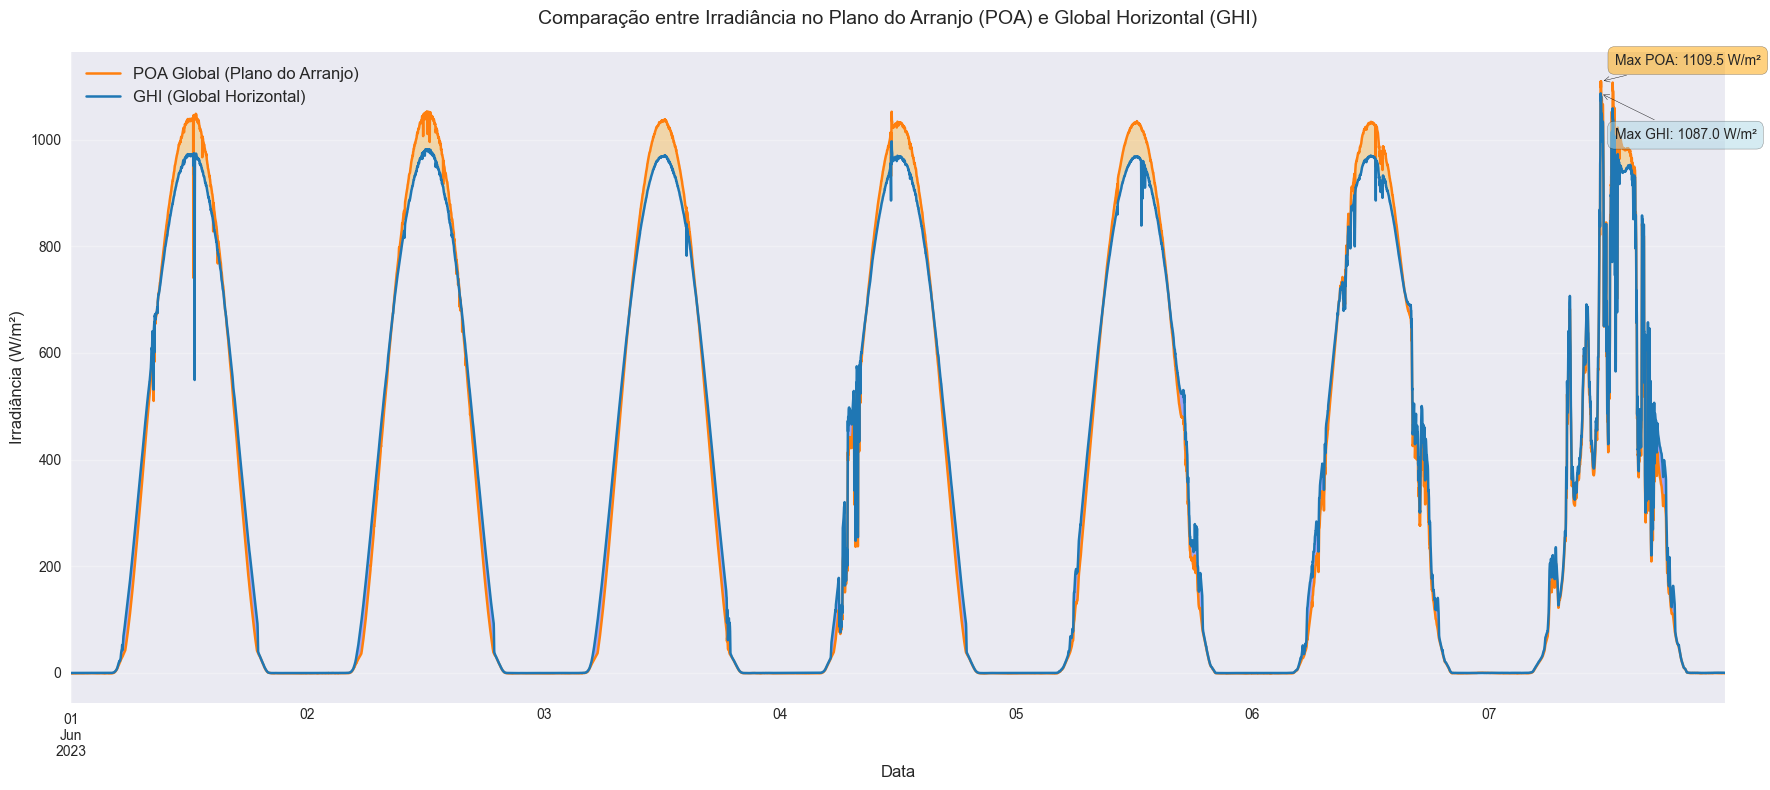


=== Métricas Comparativas ===
     Máximo (W/m²)  Média (W/m²)  Energia Total (kWh/m²)
POA        1109.52        346.64                 3494.18
GHI        1087.00        347.52                 3502.97


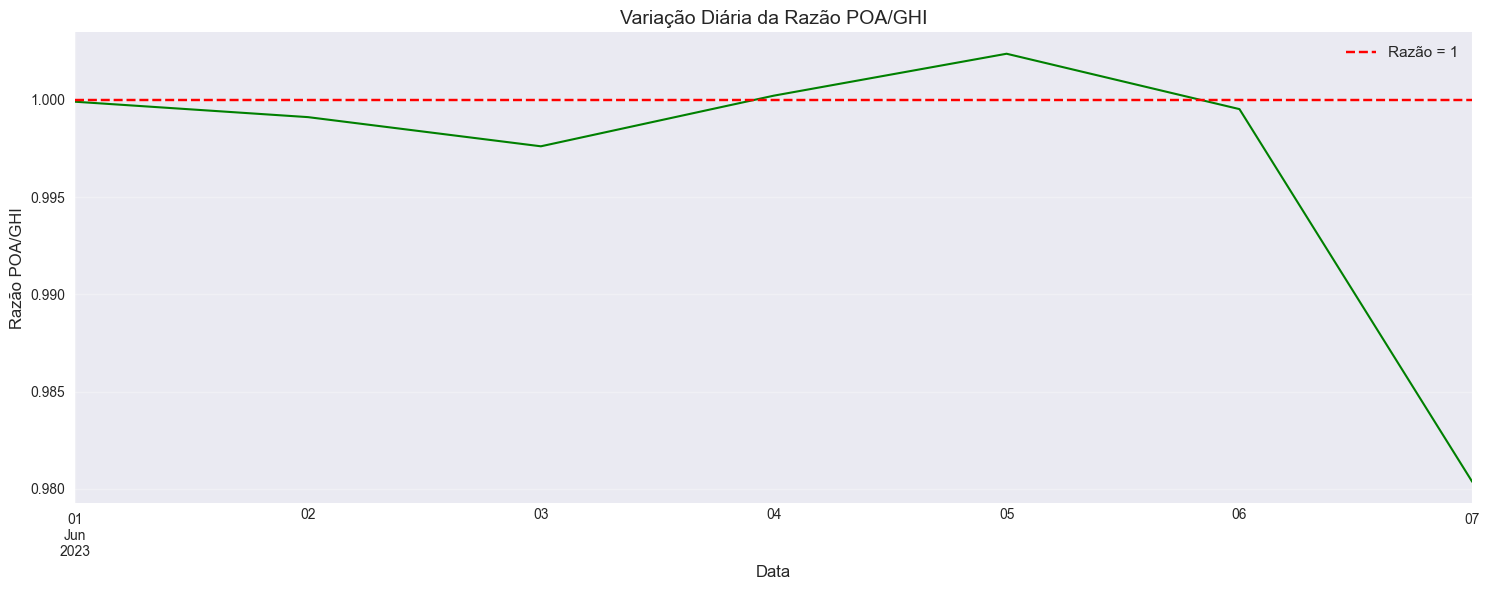

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

loc = pvlib.location.Location(
    latitude=44.0467,
    longitude=-123.0743,
    altitude=133.8,
    tz='UTC'  # ou 'America/Los_Angeles' (dependendo dos seus dados)
)

altitude=133.8
solpos = loc.get_solarposition(df_weather.index)

surface_tilt = 20
surface_azimuth = 180
solar_zenith = solpos['zenith']
solar_azimuth = solpos['azimuth']
dni = df_weather['dni']
ghi = df_weather['ghi']
dhi = df_weather['dhi']
dni_extra = pvlib.irradiance.get_extra_radiation(df_weather.index)
airmass_relative = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
pressure = pvlib.atmosphere.alt2pres(altitude = altitude)
airmass = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure)

POA_Irradiance = pvlib.irradiance.get_total_irradiance(surface_tilt,
                                                  surface_azimuth,
                                                  solar_zenith,
                                                  solar_azimuth,
                                                  dni,
                                                  ghi,
                                                  dhi,
                                                  dni_extra=dni_extra,
                                                  airmass=airmass,
                                                  albedo=0.25,
                                                  surface_type=None,
                                                  model='isotropic', #'isotropic', 'klucher', 'haydavies', 'reindl', 'king', 'perez', 'perez-driesse'
                                                  model_perez='allsitescomposite1990') #Used only for Perez Model)
# Dados
poa = POA_Irradiance['poa_global']
ghi = df_weather['ghi']

# 1. Plot comparativo temporal aprimorado
plt.figure(figsize=(18, 8))
ax = plt.gca()

# Plot das séries com preenchimento entre elas
poa.plot(label='POA Global (Plano do Arranjo)', color='#FF7F0E', linewidth=1.8, ax=ax)
ghi.plot(label='GHI (Global Horizontal)', color='#1F77B4', linewidth=1.8, ax=ax)
plt.fill_between(poa.index, poa, ghi, where=(poa >= ghi),
                facecolor='orange', alpha=0.3, interpolate=True)
plt.fill_between(poa.index, poa, ghi, where=(poa < ghi),
                facecolor='blue', alpha=0.3, interpolate=True)

# Configurações do gráfico
plt.title('Comparação entre Irradiância no Plano do Arranjo (POA) e Global Horizontal (GHI)',
          fontsize=14, pad=20)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Irradiância (W/m²)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Adicionando anotações de valores máximos
max_poa = poa.max()
max_ghi = ghi.max()
plt.annotate(f'Max POA: {max_poa:.1f} W/m²',
             xy=(poa.idxmax(), max_poa), xytext=(10, 10),
             textcoords='offset points', ha='left', va='bottom',
             bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=0.5),
             arrowprops=dict(arrowstyle='->'))
plt.annotate(f'Max GHI: {max_ghi:.1f} W/m²',
             xy=(ghi.idxmax(), max_ghi), xytext=(10, -25),
             textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5),
             arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.show()

# 2. Cálculo de métricas básicas
metrics = {
    'Máximo (W/m²)': [poa.max(), ghi.max()],
    'Média (W/m²)': [poa.mean(), ghi.mean()],
    'Energia Total (kWh/m²)': [poa.sum()/1000, ghi.sum()/1000]
}

metrics_df = pd.DataFrame(metrics, index=['POA', 'GHI'])

# 3. Exibição das métricas formatadas
print("\n=== Métricas Comparativas ===")
print(metrics_df.to_string(float_format=lambda x: f"{x:.2f}"))

# 4. Análise da razão diária POA/GHI (se houver dados suficientes)
if len(poa) > 24:  # Pelo menos 1 dia de dados horários
    daily_poa = poa.resample('D').sum()/1000
    daily_ghi = ghi.resample('D').sum()/1000
    daily_ratio = daily_poa/daily_ghi

    plt.figure(figsize=(15, 6))
    daily_ratio.plot(color='green', linewidth=1.5)
    plt.axhline(y=1, color='r', linestyle='--', label='Razão = 1')
    plt.title('Variação Diária da Razão POA/GHI', fontsize=14)
    plt.ylabel('Razão POA/GHI', fontsize=12)
    plt.xlabel('Data', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nDados insuficientes para análise diária (mínimo 24 horas requeridas)")

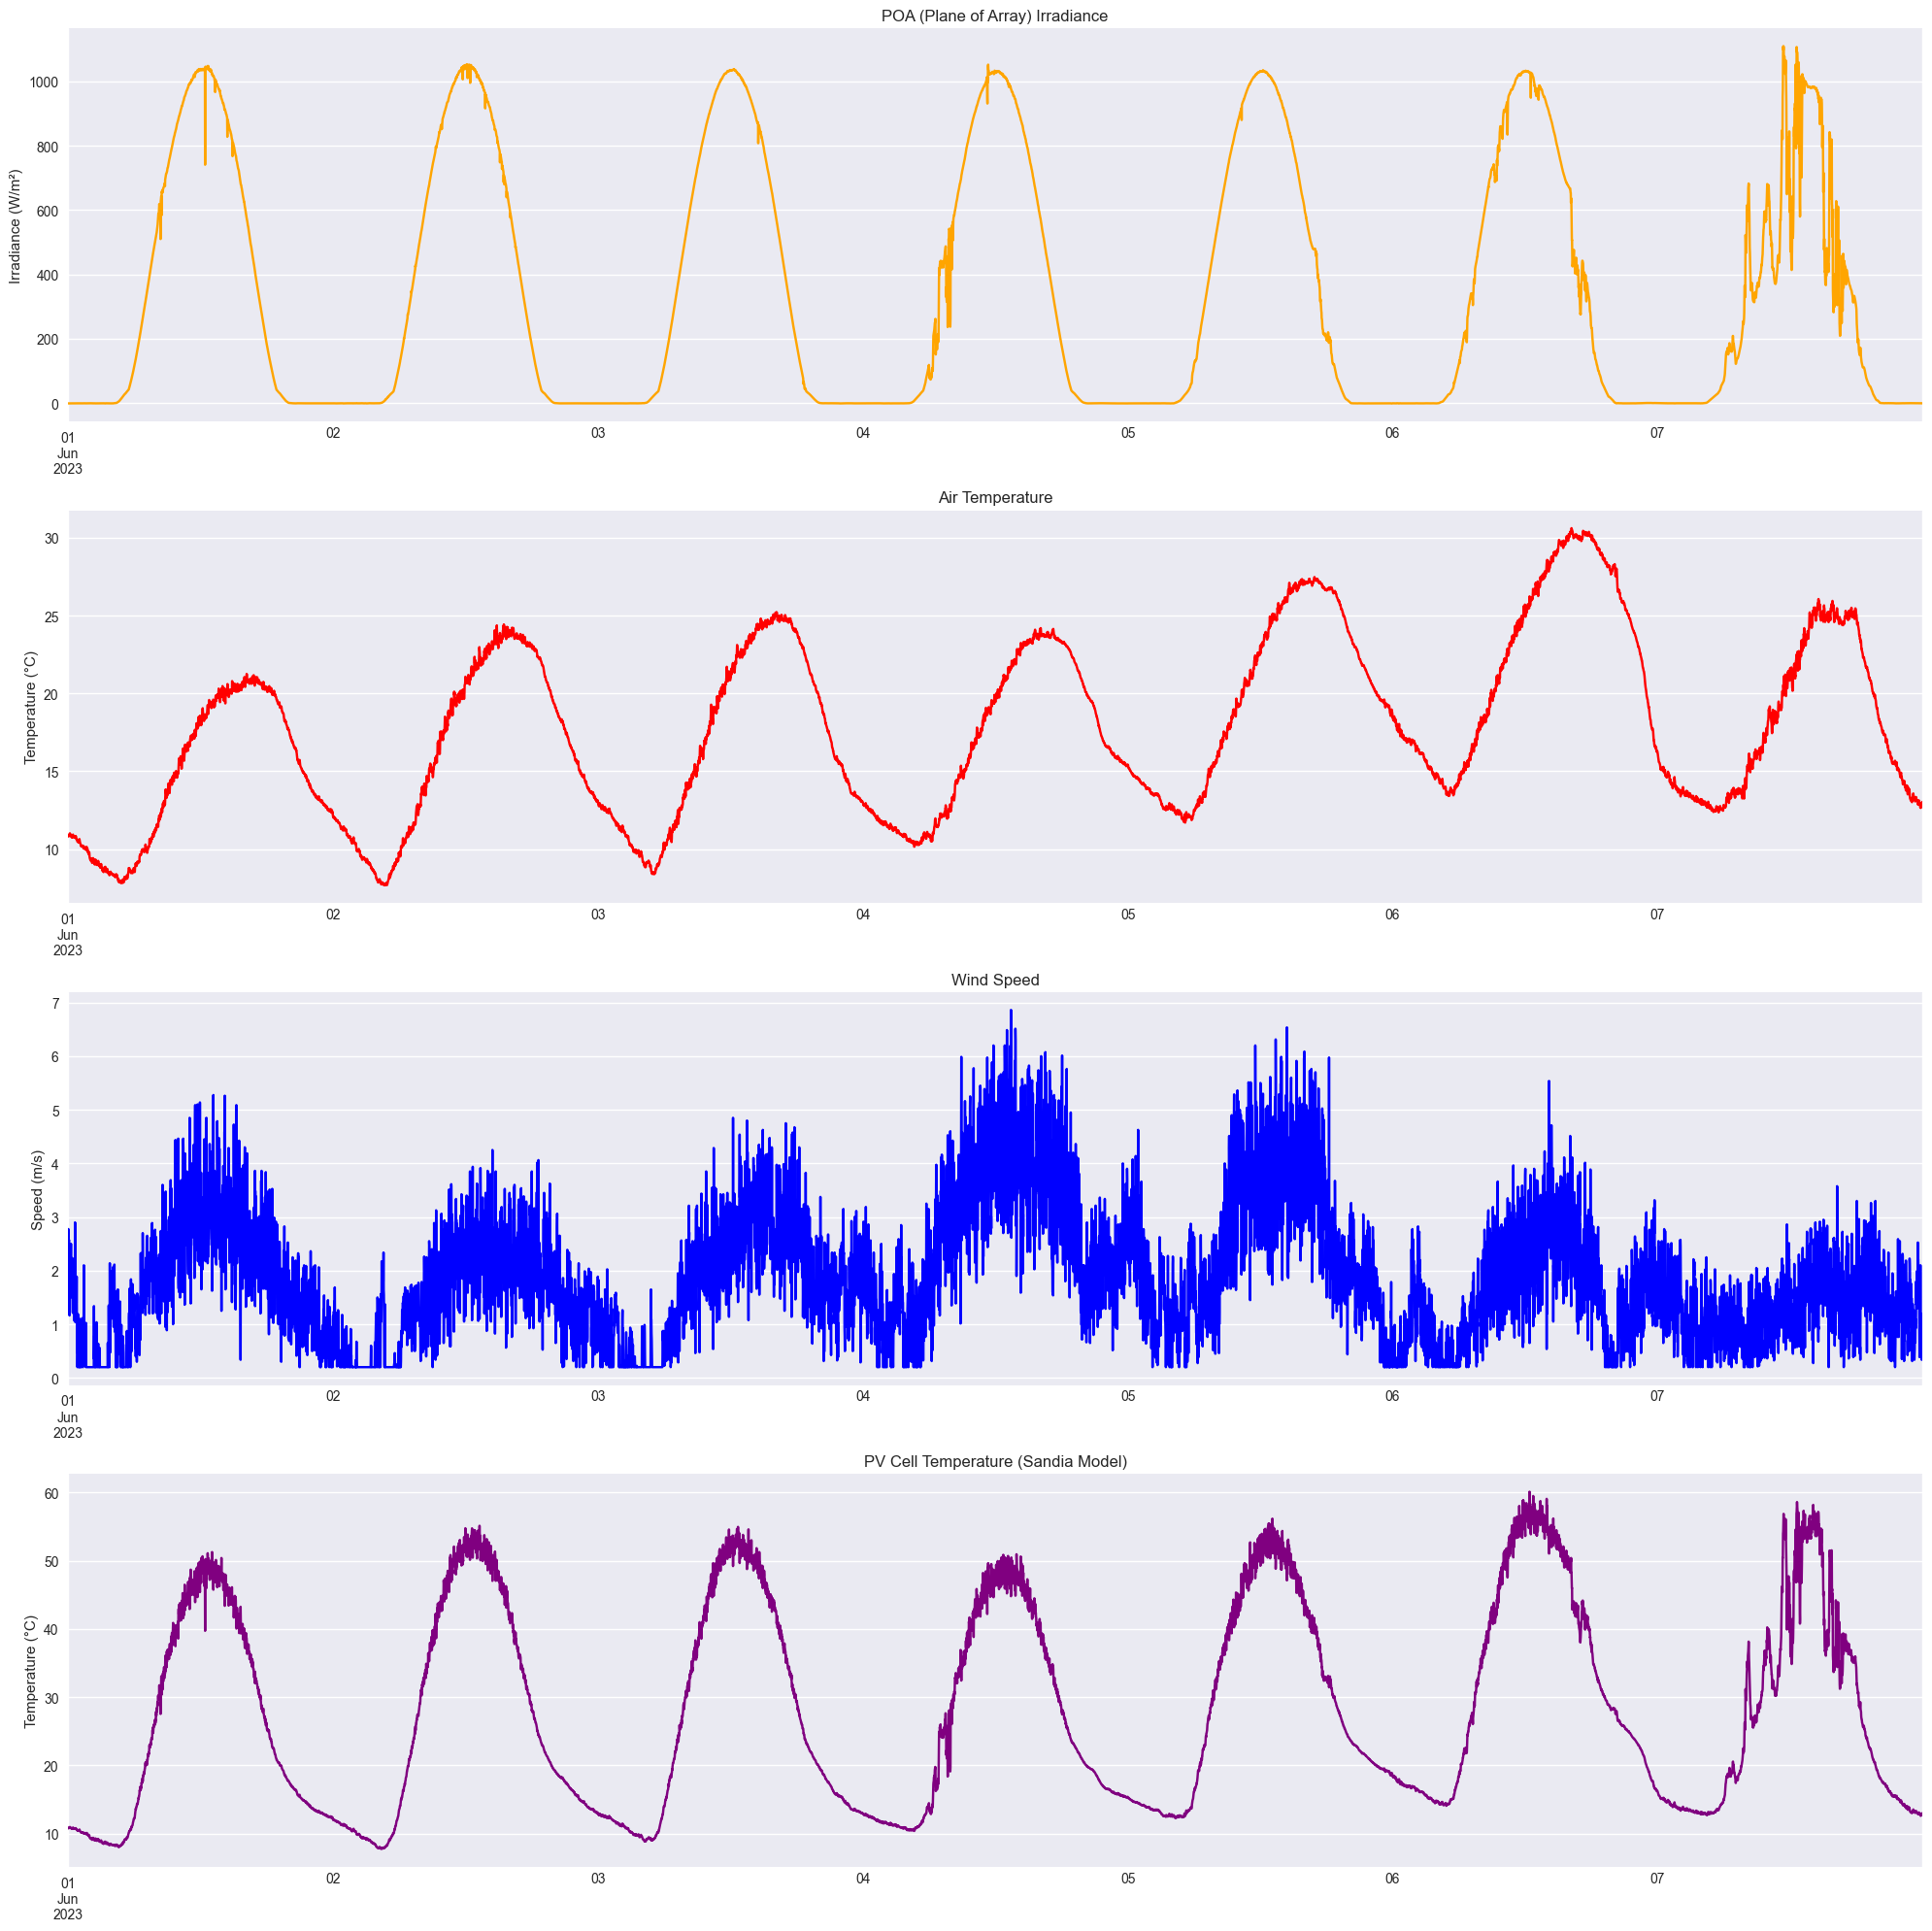

In [138]:
#Influência de Parâmetros para a Modelagem de Temperatura
#Pedir para plotarem os gráficos com
import matplotlib.pyplot as plt

# Criar figura com 4 subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))

# Ajustar espaçamento entre subplots
plt.subplots_adjust(hspace=0.4)

# Gráfico 1: poa.plot()
poa.plot(ax=axes[0], title='POA (Plane of Array) Irradiance', color='orange')
axes[0].set_ylabel('Irradiance (W/m²)')
axes[0].grid(True)

# Gráfico 2: Temperatura do ar
df_weather['temp_air'].plot(ax=axes[1], title='Air Temperature', color='red')
axes[1].set_ylabel('Temperature (°C)')
axes[1].grid(True)

# Gráfico 3: Velocidade do vento
df_weather['wind_speed'].plot(ax=axes[2], title='Wind Speed', color='blue')
axes[2].set_ylabel('Speed (m/s)')
axes[2].grid(True)

# Gráfico 4: Temperatura da célula PV
PV_Cell_Temperature_Sandia = pvlib.temperature.sapm_cell(poa_global = poa, temp_air = df_weather['temp_air'], wind_speed = df_weather['wind_speed'], a = -3.47, b = -0.0594, deltaT = 3, irrad_ref=1000.0)
PV_Cell_Temperature_Sandia.plot(ax=axes[3], title='PV Cell Temperature (Sandia Model)', color='purple')
axes[3].set_ylabel('Temperature (°C)')
axes[3].grid(True)

# Ajustar layout
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Potência em kW'}>

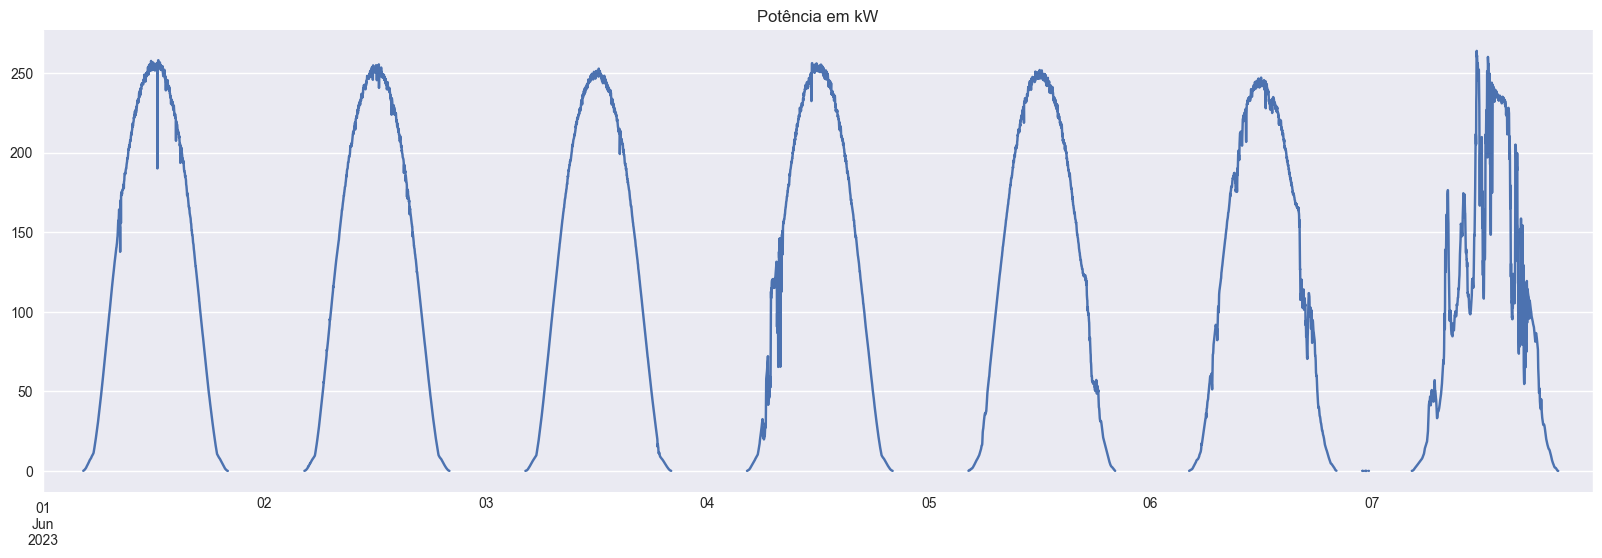

In [139]:
irrad = poa

temp_cell = PV_Cell_Temperature_Sandia

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100)

results['Key_Points']['p_mp'].plot(figsize=(20,6), title='Potência em kW')

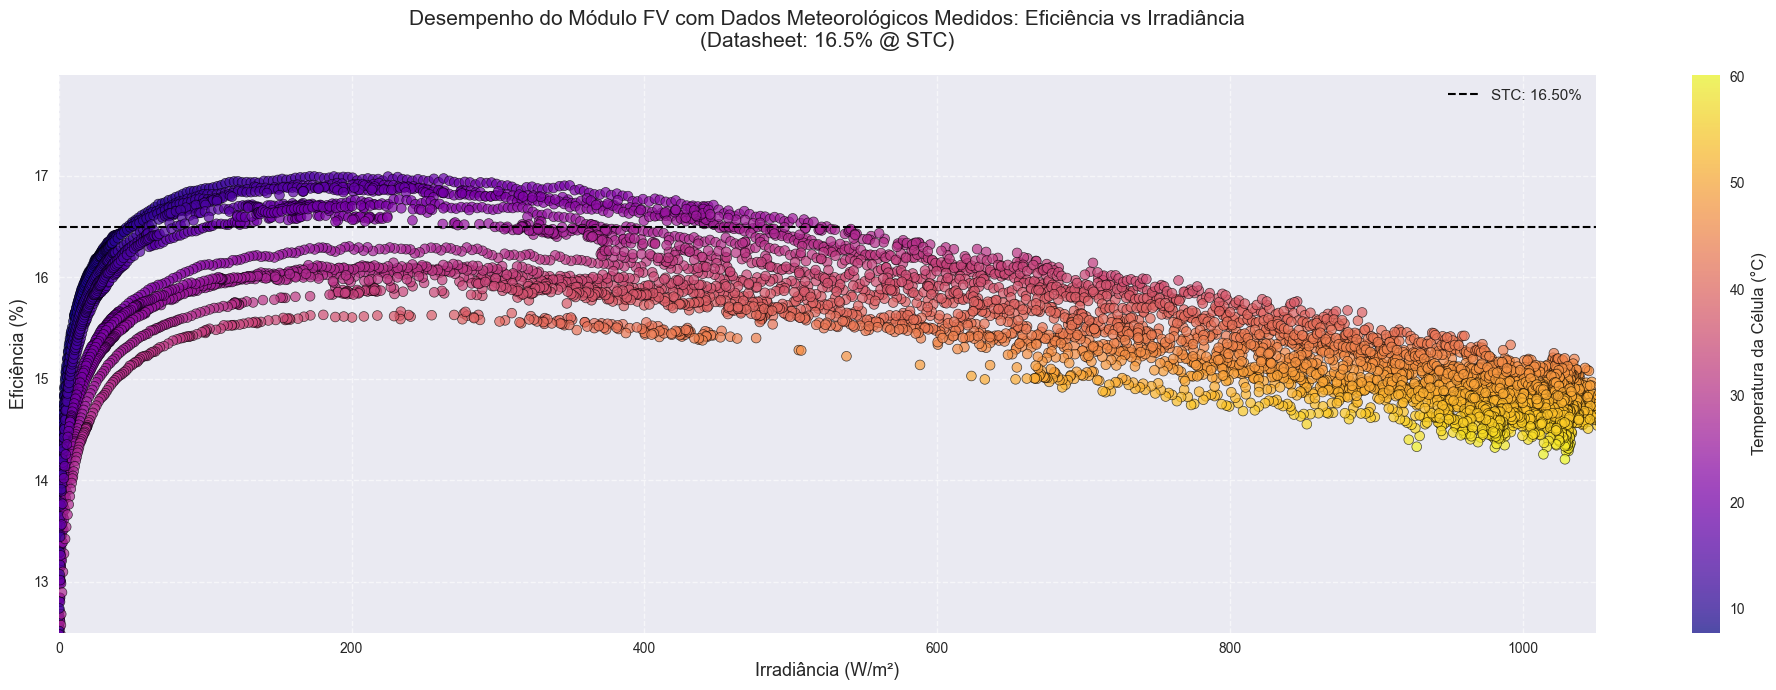

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Configuração do estilo do gráfico
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(20, 7))

# Dados
irrad = poa
temp_cell = PV_Cell_Temperature_Sandia

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref,
                            Rp_ref, R_s, EgRef, dEgdT, Gref, Tref,
                            method='lambertw', number_of_points=100)
eff = (results['Key_Points']['p_mp'])/(A_c*irrad) * 100  # Eficiência em %

# Criando o scatter plot com mapa de cores baseado na temperatura
scatter = plt.scatter(
    irrad, 
    eff, 
    c=temp_cell,  # Cor varia com a temperatura
    cmap='plasma',  # Mapa de cores (pode usar 'plasma', 'inferno', etc.)
    alpha=0.7,
    edgecolors='k',
    linewidths=0.5
)

# Barra de cores (legend)
cbar = plt.colorbar(scatter)
cbar.set_label('Temperatura da Célula (°C)', fontsize=12)

# Linha horizontal no valor STC
plt.axhline(y=16.5, color='black', linestyle='--', linewidth=1.5,
           label=f'STC: {16.5:.2f}%')

# Elementos gráficos
plt.title('Desempenho do Módulo FV com Dados Meteorológicos Medidos: Eficiência vs Irradiância\n(Datasheet: 16.5% @ STC)',
         fontsize=15, pad=20)
plt.xlabel('Irradiância (W/m²)', fontsize=13)
plt.ylabel('Eficiência (%)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)

# Configurações finais
plt.xlim(0, 1050)
plt.ylim(12.5, max(16.5, np.max(eff)) + 1)
plt.legend(loc='upper right', fontsize=11, framealpha=1)
plt.tight_layout()

plt.show()

4. Aplicação de Métricas para Avaliação de Performance da Usina FV

- Detalhe: Precisamos converter a potência para energia! Como a resolução de tempo que estamos usando nesse tempo é minuto a minuto, devemos dividir a potência por 60 (já que uma hora é composta por 60 minutos). Em casos de datasets com resolução de 15 em 15 min é a mesma história, mas a divisão é por 4, já que 15 min equivalem 1/4 de uma hora.

- Performance Ratio

O performance ratio (PR) é a métrica mais conhecida para avaliação de performance de uma usina, ou seja, para medir a sua "saúde". Essa que vamos usar no projeto é a padrão da norma IEC 61724-1. Existem variações do PR, considerando perdas conhecidas e esperadas na nossa modelagem, dando espaço para investigação de outras perdas que não foram possíveis serem estimadas. 

Por definição, o PR é a comparação da Eficiência medida do sistema em relação à eficiência esperada. Contudo, para fins práticos, o rearranjo matemático nos permite proporcionar uma equação mais direta, onde medimos a geração DC ou AC (Na prática usamos a geração AC mesmo) e comparamos com o cenário modelado (Potência em STC do sistema vezes as horas de sol pleno).

<Axes: title={'center': 'Performance Ratio (PR) - Potência Normalizada'}>

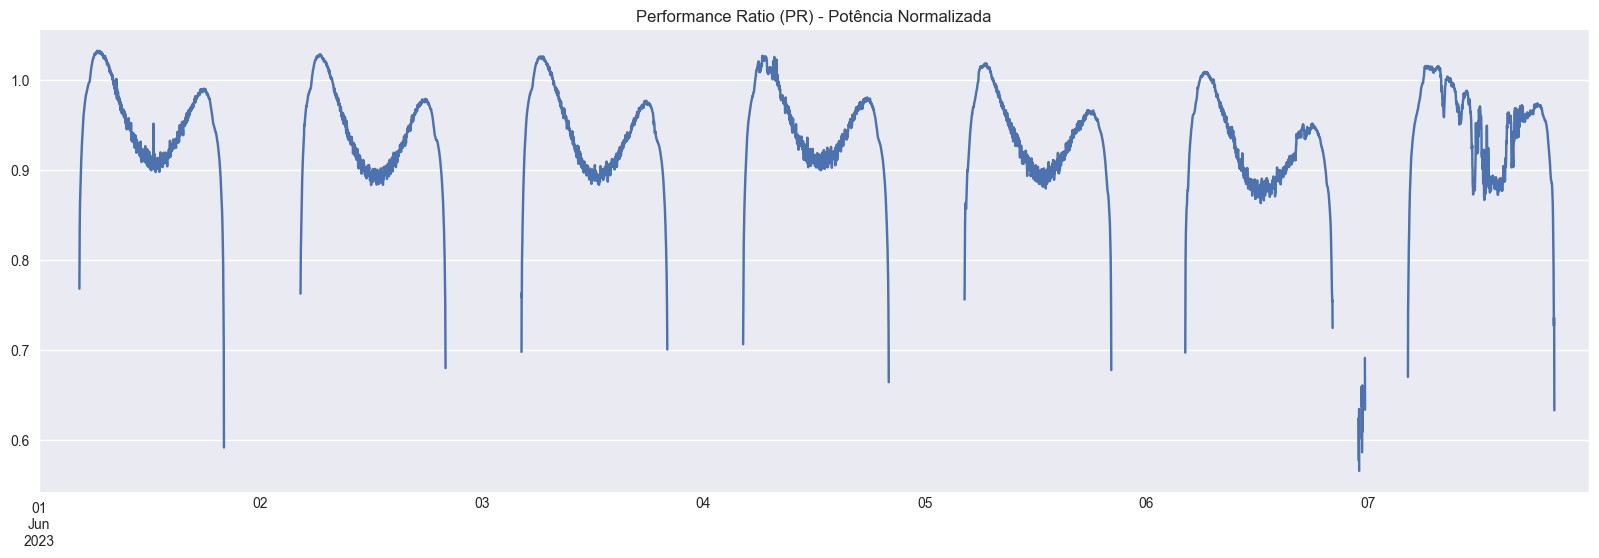

In [ ]:
#PR ao longo do tempo
Energy = results['Key_Points']['p_mp']/60

Irradiation = irrad/60

PR = Energy/(Irradiation/1000*Vmp*Imp)
PR.plot(figsize=(20,6), title='Performance Ratio (PR) - Potência Normalizada')

In [150]:
#PR Total. Pode ser extendida para período mensal e anual.
PR = Energy.sum()/(Irradiation.sum()/1000*Vmp*Imp)
PR

0.930738566526263

- Yield Final (Yf)

Essa métrica refere-se à quantidade de horas em que a usina está gerando a nível STC (potência do sistema em sob STC)

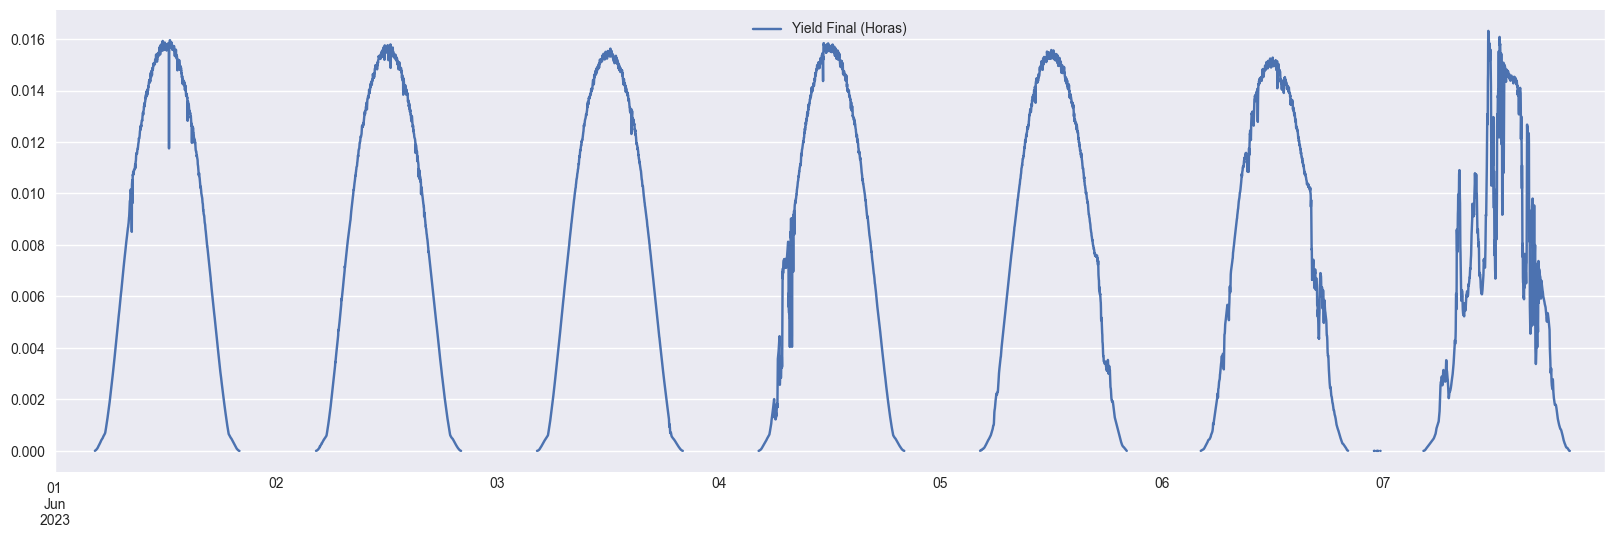

In [ ]:
Yf = Energy/(Vmp*Imp)
Yf.plot(figsize=(20,6), label = 'Yield Final (Horas)')
plt.legend()

In [ ]:
#Total de Horas em que o Sistema Gerou em Potência de STC
Yf = Energy.sum()/(Vmp*Imp)
Yf

54.20279041949838

- Yield Referencial (Yr)

Aqui é o cálculo para determinar a quantidade de horas de sol pleno no plano do módulo. Vocês podem adaptar para GHI quanto para POA. 

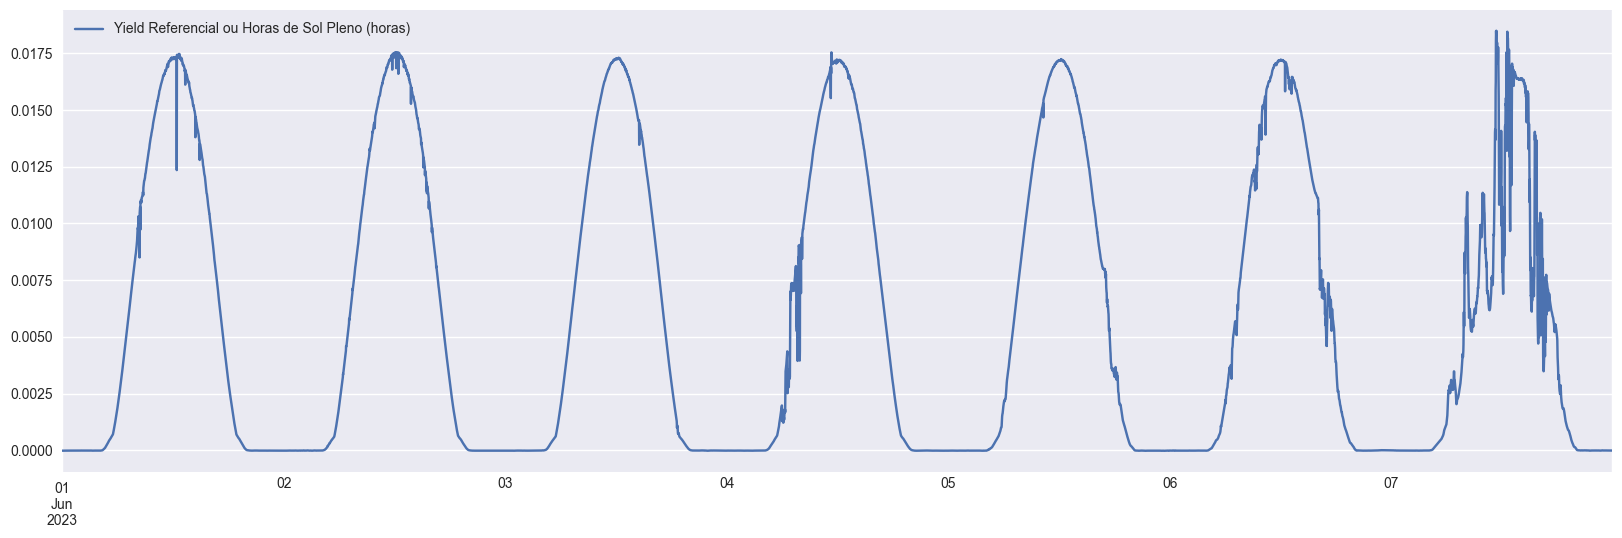

In [ ]:
Yr = Irradiation/1000
Yr.plot(figsize=(20,6), label = 'Yield Referencial ou Horas de Sol Pleno (horas)')
plt.legend()

In [ ]:
#Total de Horas de Sol Pleno
Yr.sum()

58.236321528822046

- Fator de Capacidade (FC)

Fator de Capacidade é uma métrica usada para verificar o quanto de energia está sendo gerado, em STC, em comparação com um cenário em que a usina estivesse gerando 24 horas em STC. É uma métrica usada até mesmo para comparar com outras fontes de energia renovável, como a eólica. 

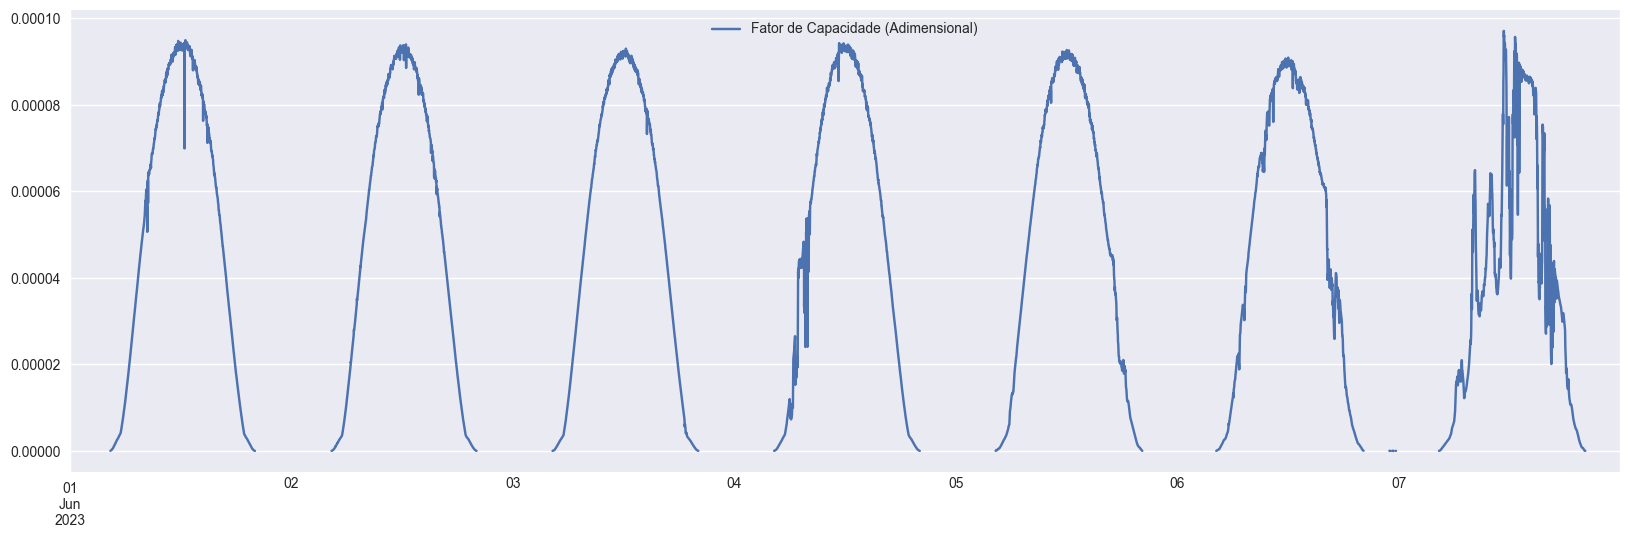

In [ ]:
Numero_de_Dias = 7 #Nesse exemplo usamos para 7 dias, devido ao período considerado para o presente exemplo, podendo ser adaptado pela quantidade de dias que quiser: Semanas, Meses, Anos...
FC = Energy/(Vmp*Imp*Numero_de_Dias*24)
FC.plot(figsize=(20,6), label = 'Fator de Capacidade (Adimensional)')
plt.legend()

In [ ]:
#A unidade é mais conhecida em Percentual
FC.sum()*100

32.263565725891894